# Intro

The features that we have available to us
1. m/z
2. adducts
3. mqns (42): "c", "f", "cl", "br", "i", "s", "p", "an", "cn", "ao", "co",
    "hac", "hbam", "hba", "hbdm", "hbd", "neg", "pos", "asb", "adb",
    "atb", "csb", "cdb", "ctb", "rbc", "asv", "adv", "atv", "aqv",
    "cdv", "ctv", "cqv", "r3", "r4", "r5", "r6", "r7", "r8", "r9",
    "rg10", "afr", "bfr"
4. Fingerprints
5. Polarization
6. Surface Area


This notebook will focus on solving this problem through a Node-Level approach. Only one graph will exist and each node is a distinct molecule and each edge is a similarity embedding from one node to another.

Our goal is to predict CCS on the node level. By aggregating similar values seen through its nearest similar neighbours

# C3S Breakdown

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.decomposition import PCA
import sqlite3
import pandas as pd

/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
conn = sqlite3.connect('/Users/reubensantoso/Xu_Lab_Files/c3s_neural_network/C3S.db')
cursor = conn.cursor()

master_df = pd.read_sql_query("SELECT * FROM master", conn)
mqn_df = pd.read_sql_query("SELECT * FROM mqns", conn)
fngr_df = pd.read_sql_query("SELECT * FROM fingerprints", conn)

c3s_df = pd.merge(master_df, fngr_df, on='g_id', how='left') #only added fingerprints. not mqn yet
c3s_df = c3s_df.dropna()
conn.close()

c3s_df.head()
print(c3s_df.shape)

(15187, 1036)


## Regression Plotting

In [3]:
# # Plotting all mz data against ccs
# plt.figure(figsize=(5, 5))
# plt.scatter(c3s_df['mz'], c3s_df['ccs'], c='blue')

# m, b = np.polyfit(c3s_df['mz'], c3s_df['ccs'], 1)
# plt.plot(c3s_df['mz'], m * c3s_df['mz'] + b, color='red')

# plt.title('mz vs ccs')
# plt.xlabel('mz')
# plt.ylabel('ccs')
# plt.show()

## PCA on MQN

In [4]:
# # Create a list of column names for MQN data
# mqn_columns = [
#     "c", "f", "cl", "br", "i", "s", "p", "an", "cn", "ao", "co",
#     "hac", "hbam", "hba", "hbdm", "hbd", "neg", "pos", "asb", "adb",
#     "atb", "csb", "cdb", "ctb", "rbc", "asv", "adv", "atv", "aqv",
#     "cdv", "ctv", "cqv", "r3", "r4", "r5", "r6", "r7", "r8", "r9",
#     "rg10", "afr", "bfr"

# ]

# mqn_pca_df = mqn_df.copy()
# mqn_pca_df = mqn_pca_df[mqn_columns] #filter out g_ID column

# ##### Apply PCA #####
# pca_mqn = PCA(n_components=2) # 2D PCA
# principalComponents = pca_mqn.fit_transform(mqn_pca_df)
# principalDf_mqn = pd.DataFrame(data=principalComponents, columns=["PCA1", "PCA2"], index=mqn_pca_df.index)
# principalDf_mqn["CCS"] = c3s_df["ccs"]

# # Adjust color range limits for better contrast
# ccs_min = principalDf_mqn["CCS"].quantile(0.05)  # Set lower bound to the 5th percentile
# ccs_max = principalDf_mqn["CCS"].quantile(0.95)  # Set upper bound to the 95th percentile

# plt.figure(figsize=(6, 6))
# plt.scatter(principalDf_mqn["PCA1"], principalDf_mqn["PCA2"], c=principalDf_mqn["CCS"], cmap="plasma", alpha=0.7, vmin=ccs_min, vmax=ccs_max)
# plt.xlabel("PCA1", fontsize=14)
# plt.ylabel("PCA2", fontsize=14)
# plt.title("PCA of MQNs Colored by CCS Values", fontsize=16)
# plt.colorbar(label="CCS")
# plt.grid(True)
# plt.show()

# print("MQN Explained Variance Ratio:", pca_mqn.explained_variance_ratio_)
# print("MQN Total Explained Variance:", sum(pca_mqn.explained_variance_ratio_))

# loadings = pd.DataFrame(pca_mqn.components_, columns=mqn_columns, index=['PCA1', 'PCA2'])
# pca1_loadings = loadings.loc['PCA1']  # Get PCA1 loadings (not absolute)
# sorted_loadings = pca1_loadings.sort_values(ascending=False)

# colors = ['red' if loading < 0 else 'blue' for loading in sorted_loadings]

# plt.figure(figsize=(12, 6))
# plt.bar(sorted_loadings.index, sorted_loadings.values, color=colors)
# plt.xlabel("MQN Number", fontsize=14)
# plt.ylabel("PCA1 Loadings", fontsize=14)
# plt.title("PCA1 Loadings for Each MQN (Sorted)", fontsize=16)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

# plt.tight_layout()
# plt.show()
# print(colors)

In [5]:
pca_column = ["adv", "hac", "hbam", "c", "asb"]

final_mqn_col = mqn_df[pca_column]
print("Shape of set with chosen mqn: ", final_mqn_col.shape)

# Now perform the merge
c3s_df = c3s_df.join(final_mqn_col.set_index(c3s_df.index))

print("Current shape of dataset with master + finger + mqn: ", c3s_df.shape)

Shape of set with chosen mqn:  (15187, 5)
Current shape of dataset with master + finger + mqn:  (15187, 1041)


In [6]:
print(c3s_df.head())

                 g_id                                name      adduct   
0  CCSBASE_C4B6CF0FE6                1-Methylnicotinamide        [M]+  \
1  CCSBASE_D0DE2590C2                   7-Methylguanosine        [M]+   
2  CCSBASE_FC56BC6B13              Thiamine pyrophosphate        [M]+   
3  CCSBASE_8A71E86DA2  beta-Nicotinamide D-ribonucleotide        [M]+   
4  CCSBASE_D4448E3E51                        Androsterone  [M+H-H2O]+   

       mass  z        mz    ccs   
0  137.0715  1  137.0715  126.4  \
1  298.1151  1  298.1151  166.5   
2  425.0444  1  425.0444  182.0   
3  335.0639  1  335.0639  165.2   
4  273.2218  1  273.2218  166.6   

                                                 smi chem_class_label   
0                            C[N+]1=CC=CC(=C1)C(=O)N   small molecule  \
1  CN1C=[N+](C2=C1C(=O)N=C(N2)N)[C@H]3[C@@H]([C@@...   small molecule   
2  CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCOP(=O)(O)OP(=...   small molecule   
3  C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)...   sma

## PCA on Adduct Encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
adduct_groups = [
    "[M+H]+", "[M+Na]+", "[M-H]-", "[M+NH4]+", "[M+K]+",
    "[M+H-H2O]+", "[M+HCOO]-", "[M+CH3COO]-", "[M+Na-2H]-"
]

# Create OneHotEncoder
adduct_encoding = OneHotEncoder(
    sparse_output=False,
    categories='auto', #encodes every other adducts larger than 5
    handle_unknown="infrequent_if_exist",
    min_frequency=5 #needs to be above 5 data samples to be encoded. if below gets grouped to others
)

adduct_encoded = adduct_encoding.fit_transform(c3s_df[['adduct']])
adduct_encoded_df = pd.DataFrame(adduct_encoded)
print(adduct_encoded_df.shape)
print(adduct_encoded_df.head())

# # Correct number of column names
# adduct_columns = []
# for val in adduct_encoding.categories_[0][:38]: # enforce only 38 values
#     adduct_columns.append(f"adduct_{val}")
# print(adduct_columns, "\n")

# Concatenate the original DataFrame with the one-hot encoded DataFrame
adduct_encoded_df.head()
c3s_df = c3s_df.join(adduct_encoded_df.set_index(c3s_df.index))
c3s_df.head()

(15187, 38)
    0    1    2    3    4    5    6    7    8    9   ...   28   29   30   31   
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  \
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    32   33   34   35   36   37  
0  0.0  0.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  1.0  0.0  
2  0.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 38 columns]


,g_id,name,adduct,mass,z,mz,ccs,smi,chem_class_label,src_tag,...,28,29,30,31,32,33,34,35,36,37
0,CCSBASE_C4B6CF0FE6,1-Methylnicotinamide,[M]+,137.0715,1,137.0715,126.4,C[N+]1=CC=CC(=C1)C(=O)N,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CCSBASE_D0DE2590C2,7-Methylguanosine,[M]+,298.1151,1,298.1151,166.5,CN1C=[N+](C2=C1C(=O)N=C(N2)N)[C@H]3[C@@H]([C@@...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,CCSBASE_FC56BC6B13,Thiamine pyrophosphate,[M]+,425.0444,1,425.0444,182.0,CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCOP(=O)(O)OP(=...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CCSBASE_8A71E86DA2,beta-Nicotinamide D-ribonucleotide,[M]+,335.0639,1,335.0639,165.2,C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CCSBASE_D4448E3E51,Androsterone,[M+H-H2O]+,273.2218,1,273.2218,166.6,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2CC[C@]4...,small molecule,zhou1016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA on Fingerprints

In [9]:
# fngr_df = fngr_df.drop(columns = ['g_id'])

In [10]:
# pca_finger = PCA(n_components=2)
# principalComponents_finger = pca_finger.fit_transform(fngr_df)

# principalDf_finger = pd.DataFrame(data=principalComponents_finger, columns=["PCA1", "PCA2"], index=fngr_df.index)
# principalDf_finger["CCS"] = c3s_df["ccs"]  # Add CCS values for visualization

# ccs_min = principalDf_finger["CCS"].quantile(0.05)  # Set lower bound to the 5th percentile
# ccs_max = principalDf_finger["CCS"].quantile(0.95)  # Set upper bound to the 95th percentile

# plt.figure(figsize=(6, 6))
# plt.scatter(principalDf_finger["PCA1"], principalDf_finger["PCA2"], c=principalDf_finger["CCS"], cmap="plasma", alpha=0.7, vmin=ccs_min, vmax=ccs_max)
# plt.xlabel("PCA1", fontsize=14)
# plt.ylabel("PCA2", fontsize=14)
# plt.title("PCA of Fingerprints Colored by CCS Values", fontsize=16)
# plt.colorbar(label="CCS")
# plt.grid(True)
# plt.show()

# # --- Print explained variance for Adducts ---
# print("Fingerprint Explained Variance Ratio:", pca_finger.explained_variance_ratio_)
# print("Fingerprint Total Explained Variance:", sum(pca_finger.explained_variance_ratio_))


# loadings = pd.DataFrame(pca_finger.components_, columns=fngr_df.columns, index=['PCA1', 'PCA2'])
# pca1_loadings = loadings.loc['PCA1']  # Get PCA1 loadings (not absolute)
# sorted_loadings = pca1_loadings.sort_values(ascending=False)

# colors = ['red' if loading < 0 else 'blue' for loading in sorted_loadings]

# plt.figure(figsize=(12, 6))
# plt.bar(sorted_loadings.index, sorted_loadings.values, color=colors)
# plt.xlabel("MQN Number", fontsize=14)
# plt.ylabel("PCA1 Loadings", fontsize=14)
# plt.title("PCA1 Loadings for Each Fingerprint (Sorted)", fontsize=16)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

# plt.tight_layout()
# plt.show()

# Final Dataset

In [11]:
c3s_df_final = c3s_df.copy()
c3s_df_final = c3s_df_final.drop(columns=['g_id', 'adduct', 'name', 'mass', 'z', 'smi', 'chem_class_label', 'src_tag', 'ccs_type', 'ccs_method'], axis=1)

print(c3s_df_final.head())
print(c3s_df_final.columns)

         mz    ccs    0    1    2    3    4    5    6    7  ...   28   29   
0  137.0715  126.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  \
1  298.1151  166.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  425.0444  182.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  335.0639  165.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  273.2218  166.6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0   

    30   31   32   33   34   35   36   37  
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1069 columns]
Index([ 'mz', 'ccs',   '0',   '1',   '2',   '3',   '4',   '5',   '6',   '7',
       ...
          28,    29,    30,    31,    32,    33,    34,    35,    36,    37],
      dtype='object', length=1069)


# Building GNN - Train Set



In [12]:
print(c3s_df_final.shape)
print(c3s_df_final.columns)

(15187, 1069)
Index([ 'mz', 'ccs',   '0',   '1',   '2',   '3',   '4',   '5',   '6',   '7',
       ...
          28,    29,    30,    31,    32,    33,    34,    35,    36,    37],
      dtype='object', length=1069)


## Building Features

In [13]:
use_subset = False

if use_subset:
  c3s_df_final = c3s_df_final.sample(n=8000, random_state=42)

print(c3s_df_final.shape)
c3s_df_final.head()

(15187, 1069)


,mz,ccs,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,36,37
0,137.0715,126.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,298.1151,166.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,425.0444,182.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,335.0639,165.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,273.2218,166.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# X_ = c3s_df_final.drop("ccs", axis=1)
# y_ = c3s_df_final["ccs"]

# print(X_.head())
# print(y_.head())

In [15]:
# from numpy import concatenate, percentile, digitize, array
# from sklearn.model_selection import StratifiedShuffleSplit
# from typing import List, Any, Optional, Tuple

# # self.X_             (full array of features -> set by self.featurize(...))
# # self.y_             (full array of labels -> set by self.featurize(...))



# def _get_categorical_y(
#                            ) -> Any :
#         """
#         transforms the labels into 'categorical' data (required by StratifiedShuffleSplit) by performing a binning
#         operation on the continuous label data. The binning is performed using the rough distribution of label values
#         with the following bounds (based on quartiles):
#                 Q1            Q2             Q3
#                 |             |              |
#           bin1  | bin2 | bin3 | bin4 | bin 5 | bin 6
#                        |             |
#               (Q2 - Q1 / 2) + Q1     |
#                             (Q3 - Q2 / 2) + Q2
#         Uses labels stored in the self.y_ instance variable
        
#         Returns
#         -------
#         cat_y : ``np.ndarray(int)``
#             categorical (binned) label data
#         """
#         # get the quartiles from the label distribution
#         q1, q2, q3 = percentile(y_, [25, 50, 75])
#         # get midpoints
#         mp12 = q1 + (q2 - q1) / 2.
#         mp23 = q2 + (q3 - q2) / 2.
#         # bin boundaries
#         bounds = [q1, mp12, q2, mp23, q3]
#         return digitize(y_, bounds)


# def train_test_split(
#                          stratify: str, 
#                          test_frac: float = 0.2
#                          ) -> None :
#         """
#         Shuffles the data then splits it into a training set and a test set, storing each in self.X_train_,
#         self.y_train_, self.X_test_, self.y_test_ instance variables. The splitting is done in a stratified manner
#         based on either CCS or dataset source. In the former case, the CCS distribution in the complete dataset is
#         binned into a rough histogram (8 bins) and the train/test sets are split such that they each contain similar 
#         proportions of this roughly binned CCS distribution. In the latter case, the train/test sets are split such
#         that they each preserve the rough proportions of all dataset sources present in the complete dataset.
#         This method DOES NOT get called on C3SD objects in the self.datasets_ instance variable.

#         Sets the following instance variables:
#         - self.X_train_       (training set split of features)
#         - self.y_train_       (training set split of labels)
#         - self.N_train_       (training set size) 
#         - self.X_test_        (test set split of features)
#         - self.y_test_        (test set split of labels)
#         - self.N_test_        (test set size)
#         - self.SSSplit_       (StratifiedShuffleSplit instance)

#         .. note:: 
            
#             self.featurize(...) must be called first to generate the features and labels (self.X_, self.y_)

#         Parameters
#         ----------
#         stratify : ``str``
#             specifies the method of stratification to use when splitting the train/test sets: 'source' 
#             for stratification on data source, or 'ccs' for stratification on CCS 
#         test_frac : ``float``, default=0.2
#             fraction of the complete dataset to reserve as a test set, defaults to an 80 % / 20 %
#             split for the train / test sets, respectively
#         """
#         # make sure self.featurize(...) has been called
#         # if X_ is None:
#         #     msg = 'C3SD: train_test_split: self.X_ is not initialized, self.featurize(...) must be called before ' + \
#         #             'calling self.train_test_split(...)'
#         #     raise RuntimeError(msg)
        
#         # make sure stratify is a valid option (if provided)
#         if stratify not in ['source', 'ccs']:
#             msg = 'C3SD: train_test_split: stratify="{}" invalid, must be "source" or "ccs"'.format(stratify)
#             raise RuntimeError(msg)
#         # if stratify == 'source':
#         #     # stratify on dataset source
#         #     y_cat = src_
#         # else:
#         y_cat = _get_categorical_y()

#         # initialize StratifiedShuffleSplit
#         X_ = X_.reset_index(drop=True)
#         y_ = y_.reset_index(drop=True)

#         SSSplit_ = StratifiedShuffleSplit(n_splits=1, test_size=test_frac, random_state=1234)
        
#         # split and store the X and y train/test sets as instance variables
#         for train_index, test_index in SSSplit_.split(X_, y_cat):
#             X_train_, X_test_ = X_[train_index], X_[test_index]
#             y_train_, y_test_ = y_[train_index], y_[test_index]
        
#         # store the size of the train/test sets in instance variables
#         N_train_ = X_train_.shape[0] 
#         N_test_ = X_test_.shape[0] 
        
#         return X_train_, X_test_, y_train_, y_test_

In [16]:
# features = ["mz", "adv", "hac", "hbam", "c", "asb", 'adduct_[M+H]+', 'adduct_[M+Na]+', 'adduct_[M-H]-', 'adduct_[M+NH4]+',
#        'adduct_[M+K]+', 'adduct_[M+H-H2O]+', 'adduct_[M+HCOO]-',
#        'adduct_[M+CH3COO]-', 'adduct_[M+Na-2H]-'] #15 features


c3s_target_df = c3s_df_final["ccs"]
c3s_featuers_df = c3s_df_final.drop("ccs", axis=1)


# c3s_df now has the full features we need for everything. Now train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    c3s_featuers_df, c3s_target_df, test_size=0.2, random_state=42
)

# X_train, X_test, y_train, y_test = train_test_split("ccs")

print("training and validation set")
print(X_train.shape)
print(y_train.shape)

print("test set")
print(X_test.shape)
print(y_test.shape)

training and validation set
(12149, 1068)
(12149,)
test set
(3038, 1068)
(3038,)


## Building Edges Knn

In [17]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [18]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float)

X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float)

In [19]:
from sklearn.neighbors import NearestNeighbors

if "g_id" in fngr_df.columns:
    fngr_df = fngr_df.drop(columns=["g_id"])


#1. Building Graph for Train Set
knn = NearestNeighbors(n_neighbors=5, metric='jaccard') #use jaccard similarity to find 5 nearest neighbours
knn.fit(X_train[fngr_df.columns]) # Fit the nearest neighbors estimator from the training dataset based on fingerprints

# Compute the (weighted) graph of k-Neighbors for points in X. returns a list of edges
knn_graph_train = knn.kneighbors_graph(X_train[fngr_df.columns], mode='connectivity').tocoo()
edge_index_train = torch.tensor(np.array([knn_graph_train.row, knn_graph_train.col]), dtype=torch.long)


#2. Building graph for Test Set
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=5, metric='jaccard')
knn.fit(X_test[fngr_df.columns])  # must match column structure

knn_graph_test = knn.kneighbors_graph(X_test[fngr_df.columns], mode='connectivity').tocoo()
edge_index_test = torch.tensor(np.array([knn_graph_test.row, knn_graph_test.col]), dtype=torch.long)

/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/miniconda3/envs/database_clean/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [20]:
print(edge_index_train.shape)
print("\n")
print(edge_index_test.shape)

torch.Size([2, 60745])


torch.Size([2, 15190])


In [21]:
# import networkx as nx #library for visualizing graphs
# from scipy.sparse import coo_matrix #library for graph matrix

# coo = coo_matrix(knn_graph)

# G = nx.Graph() #initialize multiple undirected graph
# G.add_edges_from(zip(coo.row, coo.col)) #adding the points

# # node color by chem_class_label
# chem_class = c3s_df['chem_class_label'].values
# node_color = chem_class[:len(G.nodes)]

# #create mapping
# unique_chem_classes = np.unique(chem_class)
# num_chem_classes = len(unique_chem_classes)
# cmap = plt.cm.get_cmap('viridis', num_chem_classes)  # Use a discrete colormap
# color_mapping = {chem_class: cmap(i) for i, chem_class in enumerate(unique_chem_classes)}
# node_colors = [color_mapping[chem_class] for chem_class in node_color]


# # Plot
# fig, ax = plt.subplots(figsize=(10, 8))
# pos = nx.spring_layout(G, seed=42)  # force-directed layout
# nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, ax=ax)
# edges = nx.draw_networkx_edges(G, pos, edge_color='lightgray', ax=ax)
# plt.title("Fingerprint-Based Molecular Jaccard Similarity Graph")


# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_chem_classes - 1)), ax=ax)
# cbar.set_ticks(np.arange(num_chem_classes))
# cbar.set_ticklabels(unique_chem_classes)
# cbar.set_label('Chem Class')

# plt.axis('on')
# plt.show()

## So right now we have the following variables for training:
1. Pandas Dataframes: X_train, X_test, y_train, y_test
2. Tensors: X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
3. Edge List: edge_index_train, edge_index_test

In [22]:
def train(model, data, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        # --- Train phase ---
        model.train()
        optimizer.zero_grad()
        out = model(data) #the predicted data

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()

        optimizer.step()
        train_loss = loss.item() # Returns Mean Squared Error (MSE) — not the sum of differences.
        train_history.append(train_loss)

        # --- Val phase ---
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            val_loss_item = val_loss.item()
            val_history.append(val_loss_item)

            # --- True MRE calculation --- (not MRE Loss)
            abs_y_error_train = torch.abs(out[data.train_mask] - data.y[data.train_mask])
            mre_train = torch.mean(100. * abs_y_error_train / data.y[data.train_mask]) 
            
            abs_y_error_val = torch.abs(val_out[data.val_mask] - data.y[data.val_mask])
            mre_val = torch.mean(100. * abs_y_error_val / data.y[data.val_mask]) 
            
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss_item:.4f}")
        print(f"True MRE Train: {mre_train:.4f}, True MRE Val: {mre_val:.4f}")

    return train_history, val_history, model


# Example plot function to visualize the loss histories
def plot_history(histories):
    for h in histories:
        epochs = range(1, len(h['train_loss']) + 1)
        plt.plot(epochs, h['train_loss'], label=f"{h['name']} Train Loss")
        plt.plot(epochs, h['val_loss'], label=f"{h['name']} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [23]:
class GNN_NodeLevel(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3):
        """
        GNN for node-level regression (CCS prediction per molecule node).
        """
        super(GNN_NodeLevel, self).__init__()
        torch.manual_seed(1234)

        self.dropout_rates = [0.5, 0.3]

        self.conv1 = GCNConv(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)

        self.conv2 = GCNConv(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.conv3 = GCNConv(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)

        self.output = Linear(hidden3, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[0], training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rates[1], training=self.training)

        x = self.output(x)
        return x.squeeze()  # transforms the data into: [num_nodes, 1]

In [24]:
# Training Node Level Model
from sklearn.model_selection import KFold
from itertools import product
from torch_geometric.utils import subgraph
from torch_geometric.data import Data

data_train_val = Data(
    x=X_train_tensor,
    y=y_train_tensor,
    edge_index=edge_index_train
).to(device)

data_test = Data(
    x=X_test_tensor,
    y=y_test_tensor,
    edge_index=edge_index_test
).to(device)


learning_rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.1]
hidden_layer_configs = [
    # (520, 260, 130),
    # (520, 260, 5),
    (256, 128, 64),
    (128, 64, 32),
]
# 3 settings x each setting 3 Kfolds x each fold 70 epochs = 630 iters

grid = list(product(learning_rates, hidden_layer_configs))


=== Grid 1/16 | LR=0.001, Hidden=(256,128,64) ===
Fold 1/3
Epoch 1/200 | Train Loss: 49392.1602, Val Loss: 49402.7148
True MRE Train: 100.0911, True MRE Val: 99.8522
Epoch 2/200 | Train Loss: 49331.0859, Val Loss: 49343.0547
True MRE Train: 100.0816, True MRE Val: 99.8029
Epoch 3/200 | Train Loss: 49290.8164, Val Loss: 49299.5039
True MRE Train: 100.0846, True MRE Val: 99.7751
Epoch 4/200 | Train Loss: 49254.5039, Val Loss: 49322.5547
True MRE Train: 100.0733, True MRE Val: 99.8058
Epoch 5/200 | Train Loss: 49221.6484, Val Loss: 49348.1484
True MRE Train: 100.0651, True MRE Val: 99.8389
Epoch 6/200 | Train Loss: 49194.9258, Val Loss: 49366.6484
True MRE Train: 100.0582, True MRE Val: 99.8645
Epoch 7/200 | Train Loss: 49167.7500, Val Loss: 49381.7539
True MRE Train: 100.0473, True MRE Val: 99.8870
Epoch 8/200 | Train Loss: 49147.4727, Val Loss: 49388.9023
True MRE Train: 100.0343, True MRE Val: 99.9029
Epoch 9/200 | Train Loss: 49121.2070, Val Loss: 49387.5586
True MRE Train: 100.0168,

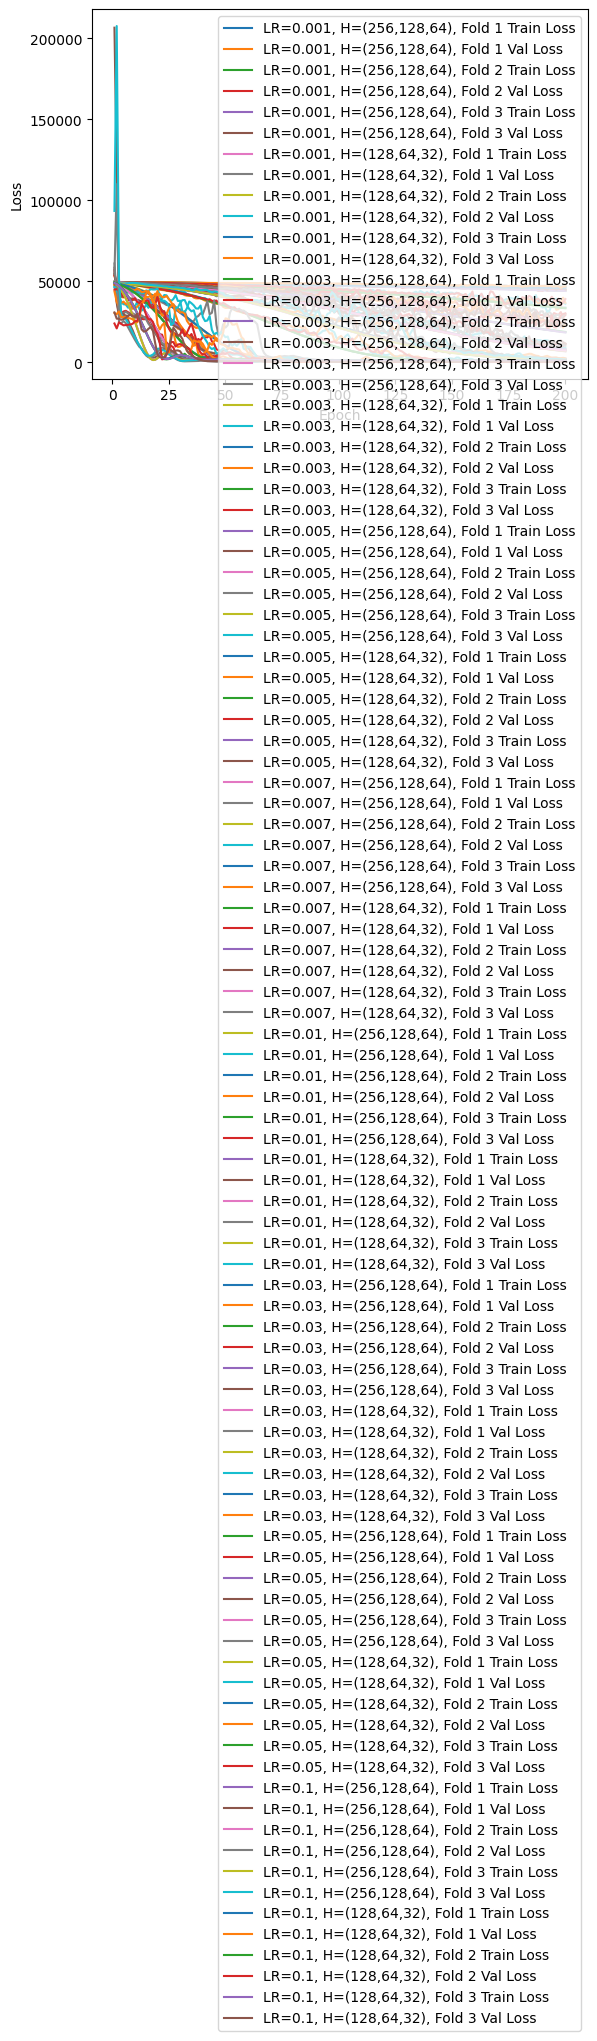

In [25]:
# Track best model
best_model = None
best_params = None

best_val_mre = float('inf')
best_train_mre = float('inf')

# Store all histories
all_histories = []

# Loop over grid of hyperparameters
for i, (lr, (h1, h2, h3)) in enumerate(grid):
    print(f"\n=== Grid {i+1}/{len(grid)} | LR={lr}, Hidden=({h1},{h2},{h3}) ===")

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_train_mres = []
    fold_val_mres = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(data_train_val.x)):
        print(f"Fold {fold+1}/{kf.get_n_splits()}")

        # Combine all indices and build subgraph
        all_idx = torch.tensor(train_idx.tolist() + val_idx.tolist(), dtype=torch.long)
        edge_index_sub, _ = subgraph(subset=all_idx, edge_index=data_train_val.edge_index, relabel_nodes=True)
        
        x_sub = data_train_val.x[all_idx] #grabs features from masked index
        y_sub = data_train_val.y[all_idx] #grabs target from masked target

        train_idx_new = torch.arange(len(train_idx)) 
        val_idx_new = torch.arange(len(train_idx), len(all_idx))

        data_fold = Data(x=x_sub, y=y_sub, edge_index=edge_index_sub) #creates a new data fold with the index masking
        mask = torch.zeros(len(all_idx), dtype=torch.bool)

        data_fold.train_mask = mask.clone()
        data_fold.train_mask[train_idx_new] = True #activate the index for train feeding
        data_fold.val_mask = mask.clone()
        data_fold.val_mask[val_idx_new] = True

        # Train the model
        model = GNN_NodeLevel(input_dim=data_fold.num_features, hidden1=h1, hidden2=h2, hidden3=h3).to(device)
        data_fold = data_fold.to(device)
        train_hist, val_hist, trained_model = train(model, data_fold, num_epochs=200, learning_rate=lr)

        # Inference for final fold MREs
        model.eval()
        with torch.no_grad():
            preds = model(data_fold)
            y_true = data_fold.y
  
            abs_y_error_train = torch.abs(preds[data_fold.train_mask] - data_fold.y[data_fold.train_mask])
            train_mre = torch.mean(100. * abs_y_error_train / data_fold.y[data_fold.train_mask]) 

            abs_y_error_val = torch.abs(preds[data_fold.val_mask] - data_fold.y[data_fold.val_mask])
            val_mre = torch.mean(100. * abs_y_error_val / data_fold.y[data_fold.val_mask]) 

        fold_train_mres.append(train_mre)
        fold_val_mres.append(val_mre)

        # Save history for plotting
        all_histories.append({
            'name': f'LR={lr}, H=({h1},{h2},{h3}), Fold {fold+1}',
            'train_loss': train_hist,
            'val_loss': val_hist
        })

    # Average MREs across folds of this setting
    avg_train_mre = sum(fold_train_mres) / len(fold_train_mres)
    avg_val_mre = sum(fold_val_mres) / len(fold_val_mres)
    print(f"Avg Train MRE: {avg_train_mre:.4f}, Avg Val MRE: {avg_val_mre:.4f}")

    if avg_val_mre < best_val_mre:
        best_val_mre = avg_val_mre
        best_train_mre = avg_train_mre
        best_model = trained_model
        best_params = {'lr': lr, 'hidden': (h1, h2, h3)}


# Final best config
print(f"\n✅ Best Config: LR={best_params['lr']}, Hidden={best_params['hidden']}")
print(f"📉 Best Train MRE%: {best_train_mre:.4f}, Best Val MRE: {best_val_mre:.4f}")

# Plot all histories
plot_history(all_histories)

# Retrain on Full Train Set

In [26]:
print(best_params)
print(best_model)

{'lr': 0.1, 'hidden': (256, 128, 64)}
GNN_NodeLevel(
  (conv1): GCNConv(1068, 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(256, 128)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(128, 64)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [27]:
# Create full train mask (all nodes included)
data_train_val.train_mask = torch.ones(data_train_val.num_nodes, dtype=torch.bool)
data_train_val.val_mask = torch.zeros(data_train_val.num_nodes, dtype=torch.bool)  # no val phase now

# Build model with best hyperparameters
best_gnn_model = GNN_NodeLevel(
    input_dim=data_train_val.num_features,
    hidden1=best_params['hidden'][0],
    hidden2=best_params['hidden'][1],
    hidden3=best_params['hidden'][2]
).to(device)

# Retrain model on all training data
train_hist, _, best_gnn_model = train(
    best_gnn_model,
    data_train_val,
    num_epochs=350,
    learning_rate=best_params['lr']
)

Epoch 1/350 | Train Loss: 49483.1953, Val Loss: nan
True MRE Train: 100.0871, True MRE Val: nan
Epoch 2/350 | Train Loss: 48423.5508, Val Loss: nan
True MRE Train: 99.1520, True MRE Val: nan
Epoch 3/350 | Train Loss: 46728.7930, Val Loss: nan
True MRE Train: 97.6280, True MRE Val: nan
Epoch 4/350 | Train Loss: 44737.4023, Val Loss: nan
True MRE Train: 95.6235, True MRE Val: nan
Epoch 5/350 | Train Loss: 42396.9492, Val Loss: nan
True MRE Train: 93.1499, True MRE Val: nan
Epoch 6/350 | Train Loss: 39593.2617, Val Loss: nan
True MRE Train: 90.1013, True MRE Val: nan
Epoch 7/350 | Train Loss: 36455.3711, Val Loss: nan
True MRE Train: 86.6004, True MRE Val: nan
Epoch 8/350 | Train Loss: 32977.4297, Val Loss: nan
True MRE Train: 82.3909, True MRE Val: nan
Epoch 9/350 | Train Loss: 29199.2773, Val Loss: nan
True MRE Train: 77.5173, True MRE Val: nan
Epoch 10/350 | Train Loss: 25353.8594, Val Loss: nan
True MRE Train: 72.1387, True MRE Val: nan
Epoch 11/350 | Train Loss: 21335.6602, Val Loss:

In [28]:
best_gnn_model.eval()
with torch.no_grad(): # disables gradient calculation -> no intermediate tensors will be saved for backpropagation
    test_preds = best_gnn_model(data_test)
    test_mre = (100 * torch.abs(test_preds - data_test.y) / (data_test.y)).mean()

print(f"\n🏁 Final Test MRE using Best Config: {test_mre:.4f}")


🏁 Final Test MRE using Best Config: 7.2717


In [29]:
with torch.no_grad():
    y_pred_train = best_gnn_model(data_train_val) #predicted values from train
    y_pred_test = best_gnn_model(data_test) #predicted values from test

#convert to numpy 
y_train_np = data_train_val.y.detach().cpu().numpy()
y_test_np = data_test.y.detach().cpu().numpy()
y_pred_train_np = y_pred_train.detach().cpu().numpy()
y_pred_test_np = y_pred_test.detach().cpu().numpy()

In [30]:
from typing import Dict, List
from matplotlib.gridspec import GridSpec
from numpy import typing as npt
from sklearn.metrics import r2_score, mean_squared_error

def compute_metrics(y: npt.NDArray[np.float64], 
                    y_pred: npt.NDArray[np.float64]
                    ) -> Dict[str, float | List[float]] :
    """
    compute a standard array of metrics between a set of predicted and reference values
    
    - R-squared (R2)
    - root mean squared error (RMSE)
    - mean absolute error (MAE)
    - median absolute erre (MDAE)
    - mean relative error % (MRE)
    - median relative error % (MDRE)
    - cumulative error distribution at the <1, <3, <5, and <10% levels (CE135A)

    Parameters
    ----------
    y : ``numpy.ndarray(float)``
    y_pred : ``numpy.ndarray(float)``
        arrays of reference and predicted values

    Returns
    -------
    summary : ``dict(...)``
        dict with set of metrics
    """
    abs_y_err = np.abs(y_pred - y)
    r2 = r2_score(y, y_pred)
    mae = np.mean(abs_y_err)
    mdae = np.median(abs_y_err)
    mre = np.mean(100. * abs_y_err / y)
    mdre = np.median(100. * abs_y_err / y)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    y_err_percent = 100. * abs_y_err / y
    cum_err = np.cumsum(np.histogram(y_err_percent, [_ for _ in range(101)])[0])
    cum_err = 100. * cum_err / np.sum(cum_err)
    ce1, ce3, ce5, ceA = cum_err[0], cum_err[2], cum_err[4], cum_err[9]
    return {
        'R2': r2, 'MAE': mae, 'MDAE': mdae, 'MRE': mre, 'MDRE': mdre, 
        'RMSE': rmse, 'CE135A': [ce1, ce3, ce5, ceA]
    }


def compute_metrics_train_test(y_train: npt.NDArray[np.float64],
                               y_test: npt.NDArray[np.float64],
                               y_pred_train: npt.NDArray[np.float64],
                               y_pred_test: npt.NDArray[np.float64]
                               ) -> Dict[str, Dict[str, float | List[float]]] :
    """
    computes a standard set of performance metrics from separate predictions
    for a training and test dataset
    - training and test set R-squared (R2)
    - training and test set root mean squared error (RMSE)
    - training and test set mean absolute error (MAE)
    - training and test set median absolute error (MDAE)
    - training and test set mean relative error (MRE)
    - training and test set median relative error (MDRE)
    - cumulative error distribution at the <1, <3, <5, and <10% levels
        for training and test set (CE135A)
    
    Parameters
    ----------
    y_train : ``numpy.ndarray(float)``
    y_test : ``numpy.ndarray(float)``
    y_pred_train : ``numpy.ndarray(float)``
    y_pred_test : ``numpy.ndarray(float)``
        arrays of reference and predicted values for training and test datasets

    Returns
    -------
    summary : ``dict(...)``
        dict with set of metrics for training and test datasets
    """
    summary = {}
    for y, y_pred, lbl in [(y_train, y_pred_train, "train"), (y_test, y_pred_test, "test")]:
        # compute metrics
        summary[lbl] = compute_metrics(y, y_pred)
    return summary

def train_test_summary_figure(summary: Dict[str, Dict[str, float | List[float]]], 
                              fig_name: str, 
                              r2_range=[0.95, 1.]):
    """
    produces a summary figure displaying the results from `compute_metrics_train_test`
    
    Parameters
    ----------
    summary : ``dict(...)``
        summary dict returned from `compute_metrics_train_test`
    fig_name : ``str``
        file name to save the generated plot under 
    r2_range : ``list(float))``, default=[0.95, 1.]]
        lower and upper bounds of R-squared y axis 
    """
    fig = plt.figure(figsize=(5, 3))
    gs = GridSpec(1, 4, figure=fig, width_ratios=[1.2, 3, 2, 5])
    
    # R-squared
    ax1 = fig.add_subplot(gs[0])
    rsq_trn = summary['train']['R2']
    rsq_tst = summary['test']['R2']
    w1 = 0.15
    ax1.bar([1 - w1 / 2, 1 + w1 / 2], [rsq_trn, rsq_tst], color=['b', 'r'], width=w1)
    for d in ['top', 'right']:
        ax1.spines[d].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylabel(r'R$^2$')
    ax1.set_ylim(r2_range)
    ax1.set_xlim([0.75, 1.25])
    
    # MAE, MDAE and RMSE
    ax2 = fig.add_subplot(gs[1])
    mae_trn = summary['train']['MAE']
    mae_tst = summary['test']['MAE']
    mdae_trn = summary['train']['MDAE']
    mdae_tst = summary['test']['MDAE']
    mse_trn = summary['train']['RMSE']
    mse_tst = summary['test']['RMSE']
    ax2.bar([0.875, 1.125], [mae_trn, mae_tst], color=['b', 'r'], width=0.25)
    ax2.bar([1.875, 2.125], [mdae_trn, mdae_tst], color=['b', 'r'], width=0.25)
    ax2.bar([2.875, 3.125], [mse_trn, mse_tst], color=['b', 'r'], width=0.25)
    for d in ['top', 'right']:
        ax2.spines[d].set_visible(False)
    ax2.set_xticks([1, 2, 3])
    ax2.set_xticklabels(['MAE', 'MDAE', 'RMSE'], rotation='vertical')
    ax2.set_ylabel(r'CCS (Å$^2$)')
    
    # CE135A
    ax3 = fig.add_subplot(gs[3])
    x1 = [_ - 0.125 for _ in range(1, 5)]
    y1 = [100. * summary['train']['CE135A'][i] for i in range(4)]
    x2 = [_ + 0.125 for _ in range(1, 5)]
    y2 = [100. * summary['test']['CE135A'][i] for i in range(4)]
    ax3.bar(x1, y1, color='b', width=0.25)
    ax3.bar(x2, y2, color='r', width=0.25)
    for d in ['top', 'right']:
        ax3.spines[d].set_visible(False)
    ax3.set_xlabel('pred. error (%)')
    ax3.set_xticks([1, 2, 3, 4])
    ax3.set_xticklabels(['<1', '<3', '<5', '<10'])
    ax3.set_ylabel('proportion (%)')
    # between axes 2 and 3
    
    # MRE, MDRE
    ax23 = fig.add_subplot(gs[2])
    mre_trn = summary['train']['MRE']
    mre_tst = summary['test']['MRE']
    mdre_trn = summary['train']['MDRE']
    mdre_tst = summary['test']['MDRE']
    w23 = 0.25
    ax23.bar([1 - w23 / 2, 1 + w23 / 2], [mre_trn, mre_tst], color=['b', 'r'], width=w23)
    ax23.bar([2 - w23 / 2, 2 + w23 / 2], [mdre_trn, mdre_tst], color=['b', 'r'], width=w23)
    for d in ['top', 'right']:
        ax23.spines[d].set_visible(False)
    ax23.set_xticks([1, 2])
    ax23.set_xticklabels(['MRE', 'MDRE'], rotation='vertical')
    ax23.set_ylabel('%')
    plt.tight_layout()
    plt.savefig(fig_name, dpi=400, bbox_inches='tight')

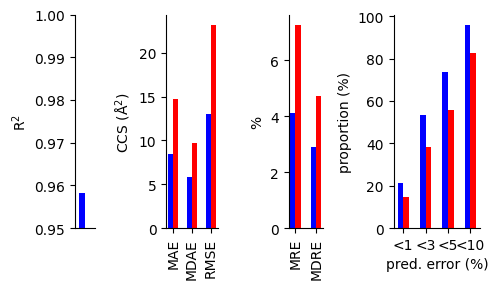

In [31]:
summary_new = compute_metrics_train_test(y_train_np, y_test_np, y_pred_train_np, y_pred_test_np)
train_test_summary_figure(summary_new, "metrics_gnn.png")

In [32]:
for key, metrics_dict in summary_new.items():
    print(key)  # This prints "train" or "test"
    for metric_name, value in metrics_dict.items():
        print(f"{metric_name}: {value}\n")


train
R2: 0.9582106835184867

MAE: 8.475000381469727

MDAE: 5.78204345703125

MRE: 4.114381313323975

MDRE: 2.9021177291870117

RMSE: 13.034480094909668

CE135A: [0.21354526134523263, 0.5326672998995483, 0.7368165697455907, 0.9599286587990898]

test
R2: 0.8710336187562879

MAE: 14.762682914733887

MDAE: 9.69171142578125

MRE: 7.271705627441406

MDRE: 4.734172344207764

RMSE: 23.191862106323242

CE135A: [0.14861778400646716, 0.38478238614501, 0.5556398860479319, 0.8246345449860031]



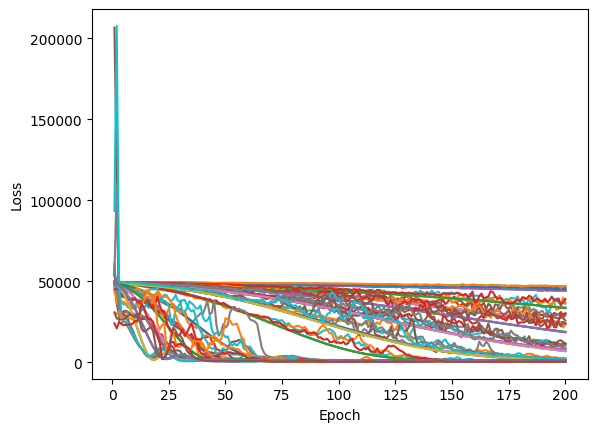

In [33]:
def plot_history(histories):
    for h in histories:
        epochs = range(1, len(h['train_loss']) + 1)
        plt.plot(epochs, h['train_loss'], label=f"{h['name']} Train Loss")
        plt.plot(epochs, h['val_loss'], label=f"{h['name']} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.legend()
    plt.show()

plot_history(all_histories)